In [265]:

%pip install --upgrade ipywidgets

In [266]:

# Initial imports
import numpy as np
import torch


import matplotlib
import matplotlib.pyplot as plt
#%matplotlib inline
from scipy import stats
import pandas as pd
from sklearn.model_selection import train_test_split
# check pytorch version
print("PyTorch version:", torch.__version__)
# use cpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)


#importing the required library forshap
#%pip install shap
import shap





PyTorch version: 1.11.0+cu113
device: cpu


## Carga del modelo 

Como Pytorch guarda las variables del modelo y los pesos y en el modelo en su totalidad hemos cogido la clase definida en el notebook principal. 

In [267]:

class TitanicSimpleNNModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(12, 12)
        self.sigmoid1 = nn.Sigmoid()
        self.linear2 = nn.Linear(12, 8)
        self.sigmoid2 = nn.Sigmoid()
        self.linear3 = nn.Linear(8, 2)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        lin1_out = self.linear1(x)
        sigmoid_out1 = self.sigmoid1(lin1_out)
        sigmoid_out2 = self.sigmoid2(self.linear2(sigmoid_out1))
        return self.softmax(self.linear3(sigmoid_out2))
    
    def predict(self, x):
        if isinstance(x, np.ndarray):
            x = torch.from_numpy(x).float()
        elif isinstance(x, torch.Tensor):
            x = x.float()
            
        x = x.view(x.size(0), -1)
        output = self.forward(x)
        predicted_probs = torch.softmax(output, dim=1)
        return predicted_probs


    
    def predict_lime(self, x):
        if isinstance(x, np.ndarray):
            x = torch.from_numpy(x).float()
        elif isinstance(x, torch.Tensor):
            x = x.float()

        x = x.view(x.size(0), -1)
        output = self.forward(x)
        predicted_probs = torch.softmax(output, dim=1)
        _, predicted_labels = torch.max(predicted_probs, 1)
        return predicted_probs.detach().numpy()
    
# Declaramos una nueva instancia de clase
model_shap = TitanicSimpleNNModel()
    
    

Observamos que la carga del modelo ha sido un exito. 

In [268]:
model_shap = TitanicSimpleNNModel()
model_shap.load_state_dict(torch.load('../Main Notebook/titanic_fcnn.pt'))
model_shap.eval()

TitanicSimpleNNModel(
  (linear1): Linear(in_features=12, out_features=12, bias=True)
  (sigmoid1): Sigmoid()
  (linear2): Linear(in_features=12, out_features=8, bias=True)
  (sigmoid2): Sigmoid()
  (linear3): Linear(in_features=8, out_features=2, bias=True)
  (softmax): Softmax(dim=1)
)

## Cargamos los datos del dataset de entrada

En el notebook principal se han procesado los datos y una vez procesados se han guardado en un csv para eviatar volver a hacer las transformaciones necesarias. 

In [269]:
# Update path to dataset here.
dataset_path = "../Main Notebook/titanic_data.csv"
# Read dataset from csv file.
titanic_data = pd.read_csv(dataset_path)



In [270]:
titanic_data.head()

,Survived,Age,SibSp,Parch,Fare,female,male,Embark_C,Embark_Q,Embark_S,Class_1,Class_2,Class_3
0,0,22.0,1,0,7.2500,0,1,0,0,1,0,0,1
1,1,38.0,1,0,71.2833,1,0,1,0,0,1,0,0
2,1,26.0,0,0,7.9250,1,0,0,0,1,0,0,1
3,1,35.0,1,0,53.1000,1,0,0,0,1,1,0,0
4,0,35.0,0,0,8.0500,0,1,0,0,1,0,0,1


In [271]:
# Set random seed for reproducibility.
np.random.seed(131254)

# Convert features and labels to numpy arrays.
labels = titanic_data["Survived"].to_numpy()
titanic_data = titanic_data.drop(['Survived'], axis=1)
feature_names = list(titanic_data.columns)
data = titanic_data.to_numpy()

# Separate training and test sets using 
train_indices = np.random.choice(len(labels), int(0.7*len(labels)), replace=False)
test_indices = list(set(range(len(labels))) - set(train_indices))
train_features = data[train_indices]
train_labels = labels[train_indices]
test_features = data[test_indices]
test_labels = labels[test_indices]

In [272]:
titanic_data = pd.read_csv(dataset_path)
#Split data into training features and labels
X, y = titanic_data.loc[:, titanic_data.columns != 'Survived'], titanic_data['Survived']

from sklearn.model_selection import train_test_split
# split data into train and test sets
seed = 42
test_size = 0.3
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

X_train_t = torch.from_numpy((X_train.to_numpy()).astype(float)).type(torch.FloatTensor)
y_train_t = torch.from_numpy(y_train.to_numpy())
X_test_t = torch.from_numpy((X_test.to_numpy()).astype(float)).type(torch.FloatTensor)
y_test_t = torch.from_numpy(y_test.to_numpy())


In [273]:
X.shape

(891, 12)

## Implementacion de SHAP


En las siguientes celdas se ha implementado SHAP.

In [274]:
#https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/model_agnostic/Multioutput%20Regression%20SHAP.html#Get-SHAP-Values-and-Plots
# print the JS visualization code to the notebook
shap.initjs()

##### Prediccion global.

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning


  0%|          | 0/268 [00:00<?, ?it/s]

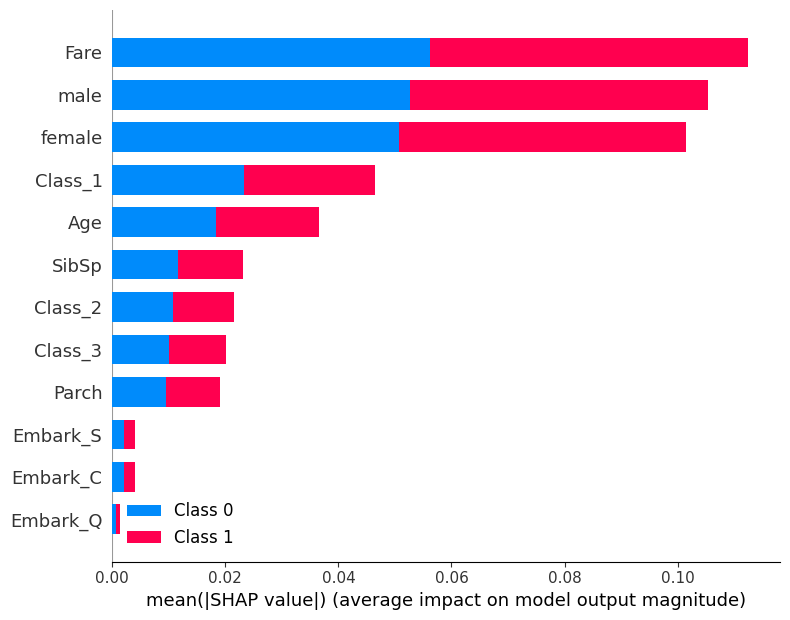

In [275]:
# rather than use the whole training set to estimate expected values, we summarize with
# a set of weighted kmeans, each weighted by the number of points they represent.
X_train_summary = shap.kmeans(X_train, 10)



# explain all the predictions in the test set
explainer = shap.KernelExplainer(model_shap.predict_lime, X_train_summary)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)

# Personalizar el título del gráfico
#plt.title("Resumen de SHAP - Contribución de características a la predicción")
#plot_title="Resumen de SHAP - Contribución de características a la predicción"
# Personalizar otros aspectos del gráfico si es necesario
# Por ejemplo, agregar etiquetas a los ejes x e y
#plt.xlabel("Valor SHAP")
#plt.ylabel("Características")


# Prediccion de un valor

Get the Shapley value for a single example.

In [327]:
explainer = shap.KernelExplainer(model = model_shap.predict_lime, data = X.head(50), link = "identity")


In [365]:
# Set the index of the specific example to explain
X_idx = 50

shap_value_single = explainer.shap_values(X = X.iloc[X_idx:X_idx+1,:], nsamples = 100)
X.iloc[X_idx:X_idx+1,:]

  0%|          | 0/1 [00:00<?, ?it/s]

,Age,SibSp,Parch,Fare,female,male,Embark_C,Embark_Q,Embark_S,Class_1,Class_2,Class_3
50,7.0,4,1,39.6875,0,1,0,0,1,0,0,1


Mostramos el funcionamiento del codigo.

In [366]:
import ipywidgets as widgets

shap.initjs()



# Create a list of tuples so that the index of the label is what is returned
tuple_of_labels = [0, 1]

# Create a widget for the labels and then display the widget
current_label = widgets.Dropdown(options=tuple_of_labels,
                              value=0,
                              description='Select Label:'
                              )

# Display the dropdown list (Note: access index value with 'current_label.value')
current_label


Dropdown(description='Select Label:', options=(0, 1), value=0)

In [375]:
# print the JS visualization code to the notebook
shap.initjs()

print(f'Current label Shown: {list_of_labels[current_label.value]}')


shap.force_plot(base_value = explainer.expected_value[current_label.value],
                shap_values = shap_value_single[current_label.value],
                features = X.iloc[X_idx:X_idx+1,:]
                )
                

Current label Shown: 0


  0%|          | 0/50 [00:00<?, ?it/s]

Current Label Shown: 0



No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


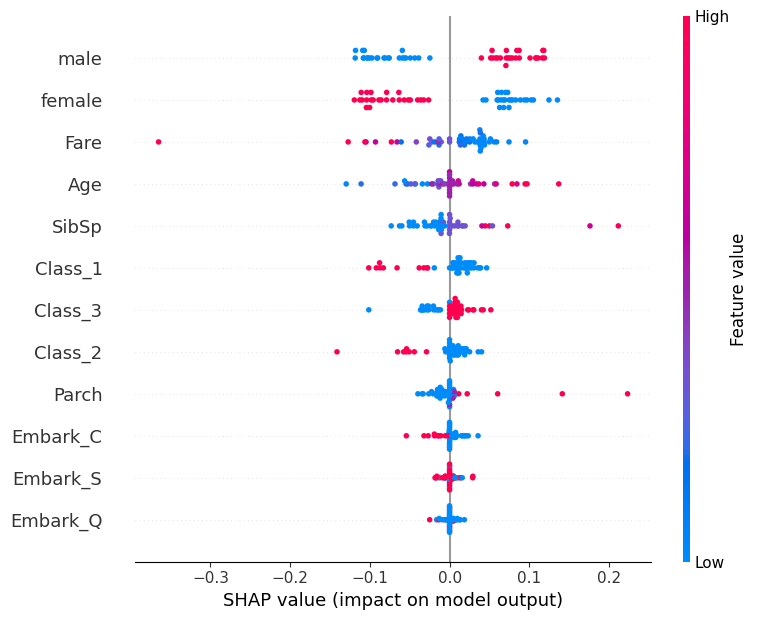

In [376]:
# Note: We are limiting to the first 50 training examples since it takes time to calculate the full number of sampels
shap_values = explainer.shap_values(X = X.iloc[0:50,:], nsamples = 100)

# print the JS visualization code to the notebook
shap.initjs()

print(f'Current Label Shown: {list_of_labels[current_label.value]}\n')

shap.summary_plot(shap_values = shap_values[current_label.value],
                  features = X.iloc[0:50,:]
                  )

In [384]:
print(f'Current Label Shown: {list_of_labels[current_label.value]}\n')

# print the JS visualization code to the notebook
shap.initjs()

shap.force_plot(base_value = explainer.expected_value[current_label.value],
                shap_values = shap_values[current_label.value],
                features = X.iloc[0:50,:]
                )

Current Label Shown: 0



In [373]:
X_tensor = X.iloc[X_idx:X_idx+1,:]
X_tensor = torch.from_numpy((X_tensor.to_numpy()).astype(float)).type(torch.FloatTensor)
model_shap.predict(X_tensor)

tensor([[0.7311, 0.2689]], grad_fn=<SoftmaxBackward0>)

In [282]:
shap.force_plot(explainer.expected_value[0], shap_values[0], X_test)

#### Prediccion con de una instancia.

In [276]:

import shap

explainer = shap.KernelExplainer(model = model.predict, data = X.head(50), link = "identity")




# Set the index of the specific example to explain
X_idx = 0

shap_value_single = explainer.shap_values(X = X.iloc[X_idx:X_idx+1,:], nsamples = 100)

NameError: name 'model' is not defined

In [ ]:
X.iloc[X_idx:X_idx+1,:]

In [ ]:

import ipywidgets as widgets

# print the JS visualization code to the notebook
shap.initjs()
# Update path to dataset here.
dataset_path = "../Main Notebook/titanic.csv"
# Read dataset from csv file.
labels = pd.read_csv(dataset_path)

# Create the list of all labels for the drop down list
list_of_labels = labels.columns.to_list()

# Create a list of tuples so that the index of the label is what is returned
tuple_of_labels = list(zip(list_of_labels, range(len(list_of_labels))))

# Create a widget for the labels and then display the widget
current_label = widgets.Dropdown(options=tuple_of_labels,
                              value=0,
                              description='Select Label:'
                              )

# Display the dropdown list (Note: access index value with 'current_label.value')
current_label


shap.summary_plot(shap_values = shap_values,
                  features = list_of_labels
                  )

NameError: name 'shap_values' is not defined

In [ ]:
# print the JS visualization code to the notebook
shap.initjs()

print(f'Current Label Shown: {list_of_labels[current_label.value]}\n')

shap.summary_plot(shap_values = shap_values[current_label.value],
                  features = X.iloc[0:50,:]
                  )

In [ ]:

shap.force_plot(base_value = explainer.expected_value,
                shap_values = shap_values[current_label.value],
                features = list_of_labels)

NameError: name 'explainer' is not defined

In [ ]:
# print the JS visualization code to the notebook
shap.initjs()

print(f'Current Label Shown: {list_of_labels[current_label.value]}\n')

shap.summary_plot(shap_values = shap_values[current_label.value],
                  features = tuple_of_labels)

NameError: name 'list_of_labels' is not defined

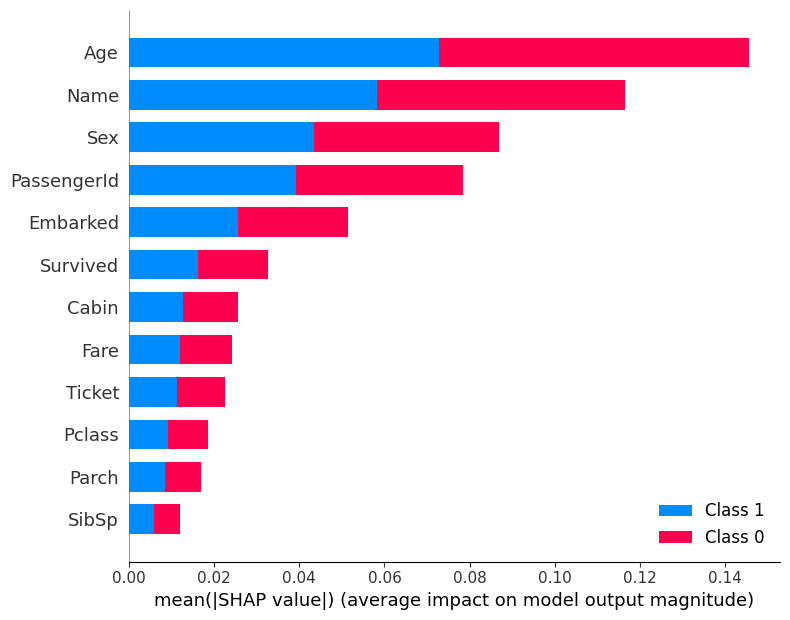

In [ ]:


shap.summary_plot(shap_values = shap_values,
                  features = list_of_labels
                  )

In [ ]:

shap.force_plot(explainer.expected_value[0], shap_values[0], test_features)

In [ ]:

shap.force_plot(explainer.expected_value[0], shap_values[0], test_features)

In [ ]:
explainer = shap.KernelExplainer(model = model_shap.predict_lime, data = test_features, link = "identity")

Using 268 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


In [ ]:
# Set the index of the specific example to explain
X_idx = 0

shap_value_single = explainer.shap_values(X = test_features[X_idx:X_idx+1,:], nsamples = 100)

Provided model function fails when applied to the provided data set.


RuntimeError: mat1 and mat2 shapes cannot be multiplied (534x13 and 12x64)

In [ ]:
test_features[X_idx:X_idx+1,:]

array([[36.    ,  0.    ,  0.    , 26.2875,  0.    ,  1.    ,  0.    ,
         0.    ,  1.    ,  1.    ,  0.    ,  0.    ]])

In [ ]:
# print the JS visualization code to the notebook
shap.initjs()

print(f'Current label Shown: {list_of_labels[current_label.value]}')

shap.force_plot(base_value = explainer.expected_value[current_label.value],
                shap_values = shap_value_single[current_label.value],
                features = list_of_labels
                )

Current label Shown: PassengerId


In [ ]:
# Note: We are limiting to the first 50 training examples since it takes time to calculate the full number of sampels
shap_values = explainer.shap_values(X = test_features[0:50,:], nsamples = 100)

  0%|          | 0/50 [00:00<?, ?it/s]